In [1]:
%run preprocessing.py

import data
merge orders and order_products__prior
size of prd features : 5
size of users features : 13
nb of usersXproducts features : 13
merge prod, user and usersXprod feature on usersXprod
order row 2000000
order row 4000000
order row 6000000
order row 8000000
order row 10000000
order row 12000000


In [15]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import  Adam


In [3]:
train0 = usersXprod[(usersXprod.eval_set == "train")]
train = train0.drop(["eval_set", "user_id", "product_id", "order_id"], axis=1)

test0 = usersXprod[(usersXprod.eval_set == "test")]
test = test0.drop(["eval_set", "user_id", "product_id", "order_id", "reordered"], axis=1)

del usersXprod
print("size of training set :", train.shape[0])
print("size of testing set  :", test.shape[0])


size of training set : 8474661
size of testing set : 4833292


In [4]:
X = train.drop(["reordered"], axis = 1)
y = train[["reordered"]]

class_weight_0 = (y.shape[0] - np.sum(y.reordered)) / y.shape[0]
class_weight_1 = np.sum(y.reordered) / y.shape[0]

print("Size of features of dataset :", X.shape[1])
print("Class weight of 0 :", class_weight_0)
print("Class weight of 1 :", class_weight_1)

Size of features of dataset : 27
Class weight of 0 : 0.9021997458069414
Class weight of 1 : 0.09780025419305857


In [14]:
X_train = np.array(X[(X.index % 10 != 0)])
X_val = np.array(X[(X.index % 10 == 0)])
y_train = y[(y.index % 10 != 0)]
y_val = y[(y.index % 10 == 0)]

y_train = np_utils.to_categorical(y_train, 2)
y_val = np_utils.to_categorical(y_val, 2)

print("Shape of X :", X_train.shape)
print("Shape of Y :", y_train.shape)


Shape of X : (7627086, 27)
Shape of Y : (7627086, 2)


In [16]:
''' set the size of mini-batch and number of epochs'''
batch_size = 128
nb_epoch = 2

print ('Building a model with dropout = 0.4')
model = Sequential()
model.add(Dense(256, input_dim = X_train.shape[1]))
model.add(Activation('softplus'))
model.add(Dropout(0.4))
model.add(Dense(512))
model.add(Activation('softplus'))
model.add(Dropout(0.4))
model.add(Dense(256))
model.add(Activation('softplus'))
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

''' Setting optimizer as Adam '''
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])
model.summary()

Building a model with dropout = 0.4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               7168      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)

Train on 7627086 samples, validate on 847575 samples
Epoch 1/2
689s - loss: 0.1542 - acc: 0.9022 - val_loss: 1.5706 - val_acc: 0.9026
Epoch 2/2
688s - loss: 0.1542 - acc: 0.9022 - val_loss: 1.5706 - val_acc: 0.9026


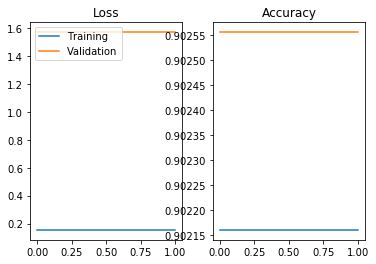

In [18]:
'''Fit models and use validation_split=0.1 '''
history_adam = model.fit(X_train, y_train,
                         batch_size = batch_size,
                         nb_epoch = nb_epoch,
                         verbose = 2,
                         shuffle = True,
                         validation_data = (X_val, y_val),
                         class_weight = {1: class_weight_1, 0: class_weight_0})
loss_adam= history_adam.history.get('loss')
acc_adam = history_adam.history.get('acc')
val_loss_adam = history_adam.history.get('val_loss')
val_acc_adam = history_adam.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss_adam)), loss_adam, label = 'Training')
plt.plot(range(len(val_loss_adam)), val_loss_adam, label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc_adam)), acc_adam,label = 'Training')
plt.plot(range(len(val_acc_adam)), val_acc_adam,label = 'Validation')
plt.title('Accuracy')
plt.show()


In [20]:
y_pred = model.predict(X_val, batch_size = 128, verbose = 0)
y_pred = pd.DataFrame(y_pred, columns = ["no", "yes"])
y_val = pd.DataFrame(y_val, columns = ["no", "yes"])
print('Misclassified samples: %d' % (y_val.no != y_pred.no).sum())
print('Accuracy : %.2f' % ((y_val.no == y_pred.no).sum() / y_val.no.shape[0]))
print('Accuracy (sklearn): %.2f' % accuracy_score(y_val.no, y_pred.no))
print("==confusion matrix==")
print(confusion_matrix(y_val.no, y_pred.no, labels = [0,1], sample_weight = None))


Misclassified samples: 82592
Accuracy : 0.90
Accuracy (sklearn): 0.90
==confusion matrix==
[[     0  82592]
 [     0 764983]]
